In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

#df = pd.concat([dff[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex', 'text', 'y_probation']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = pd.concat([dff[['text', 'y_probation']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_probation'])

In [4]:
df_0 = df[df['y_probation'] == 0].sample(frac=1)
df_1 = df[df['y_probation'] == 1].sample(frac=1)

sample_size = 1042

df = pd.concat([df_0.head(sample_size), df_1.head(sample_size)]).sample(frac=1)

In [5]:
X = df.drop('y_probation', axis=1)
y = tf.keras.utils.to_categorical(df['y_probation'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

#X4_train =  X_train[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]
#X4_test =  X_test[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]

In [8]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [9]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (529,))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (662,))
#input_4 = tf.keras.Input(dtype = tf.float32, shape = (6,))

dense_layer_1_1 = tf.keras.layers.Dense(units = 50, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_4)


dense_layer_2_1 = tf.keras.layers.Dense(units = 50, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_4)


#dense_layer_4_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_4)
#dense_layer_4_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_1)
#dense_layer_4_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_2)
#dense_layer_4_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_3)
#dropout_4_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_4_4)

In [10]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

17436


In [11]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [12]:
#concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3, dropout_4_5])
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3])

dense_layer_3 = tf.keras.layers.Dense(units = 50, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 2, activation = tf.nn.softmax)(dense_layer_3)

#model = tf.keras.Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)
model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.005), metrics=['acc'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 128)     2231808     input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 529)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 662)]        0                                            
______________________________________________________________________________________________

In [14]:
#history = model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.1)
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.1)

Train on 1687 samples, validate on 188 samples
Epoch 1/100
1687/1687 [==============================] - 3s 2ms/sample - loss: 6.2003 - acc: 0.5216 - val_loss: 1.4092 - val_acc: 0.5691
Epoch 2/100
1687/1687 [==============================] - 0s 267us/sample - loss: 0.9281 - acc: 0.6011 - val_loss: 0.7281 - val_acc: 0.6117
Epoch 3/100
1687/1687 [==============================] - 0s 274us/sample - loss: 0.7187 - acc: 0.6123 - val_loss: 0.6994 - val_acc: 0.5904
Epoch 4/100
1687/1687 [==============================] - 0s 270us/sample - loss: 0.7084 - acc: 0.6307 - val_loss: 0.6888 - val_acc: 0.6596
Epoch 5/100
1687/1687 [==============================] - 0s 289us/sample - loss: 0.7081 - acc: 0.6301 - val_loss: 0.7029 - val_acc: 0.6862
Epoch 6/100
1687/1687 [==============================] - 0s 268us/sample - loss: 0.7088 - acc: 0.6337 - val_loss: 0.6913 - val_acc: 0.6543
Epoch 7/100
1687/1687 [==============================] - 0s 260us/sample - loss: 0.7058 - acc: 0.6354 - val_loss: 0.6901 

1687/1687 [==============================] - 0s 284us/sample - loss: 0.3304 - acc: 0.9111 - val_loss: 0.3300 - val_acc: 0.9255
Epoch 60/100
1687/1687 [==============================] - 0s 291us/sample - loss: 0.3261 - acc: 0.9170 - val_loss: 0.3344 - val_acc: 0.9149
Epoch 61/100
1687/1687 [==============================] - 0s 294us/sample - loss: 0.3283 - acc: 0.9069 - val_loss: 0.3305 - val_acc: 0.9255
Epoch 62/100
1687/1687 [==============================] - 0s 292us/sample - loss: 0.3220 - acc: 0.9117 - val_loss: 0.3258 - val_acc: 0.9255
Epoch 63/100
1687/1687 [==============================] - 0s 286us/sample - loss: 0.3201 - acc: 0.9105 - val_loss: 0.3389 - val_acc: 0.9255
Epoch 64/100
1687/1687 [==============================] - 0s 284us/sample - loss: 0.3208 - acc: 0.9099 - val_loss: 0.3207 - val_acc: 0.9255
Epoch 65/100
1687/1687 [==============================] - 0s 284us/sample - loss: 0.3155 - acc: 0.9129 - val_loss: 0.3228 - val_acc: 0.9309
Epoch 66/100
1687/1687 [=========

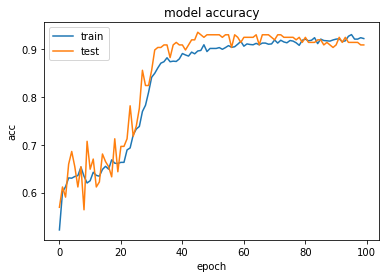

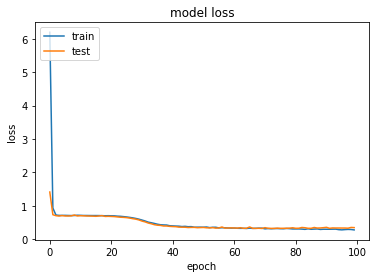

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [16]:
#score = model.evaluate(x=[X1_test, X2_test, X3_test, X4_test], y=y_test, verbose=1)
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test ACC:", score[1])

209/209 [==============================] - 0s 491us/sample - loss: 0.2766 - acc: 0.9522
Test Score: 0.2765705398680491
Test ACC: 0.9521531


In [17]:
#random, tf-idf 0.2
#10-10-10-10, 판사없이, sgd 0.01, 배치 32, 에폭 50 : 92 
#50-10-10-10, 판사없이, sgd 0.01, 배치 32, 에폭 50 : 93 94 94 // 에폭100: 90

#50-10-10-10, 판사없이, sgd 0.005, 배치 32, 에폭 50 : 93 //에폭100: 94 95 95 95// 에폭150: 94 // 에폭200: 91
#50-10-10-10, 판사없이, sgd 0.02, 배치 32, 에폭 50 : 91 

#50-10-10-10, 판사없이, sgd 0.005, 배치 2, 에폭 100 : 84
#50-10-10-10, 판사없이, sgd 0.005, 배치 4, 에폭 100 : 89
#50-10-10-10, 판사없이, sgd 0.005, 배치 8, 에폭 100 : 86
#50-10-10-10, 판사없이, sgd 0.005, 배치 16, 에폭 100 : 90
#50-10-10-10, 판사없이, sgd 0.005, 배치 64, 에폭 100 : 93


#tf-idf 0.1
#50-10-10-10, 판사없이, sgd 0.005, 배치 32, 에폭 100: 89